In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%load_ext lab_black

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import ppscore as pps
import scipy

sys.path.append("..")
from src.data import make_dataset

output_dirpath = r"..\\data\\raw"

# How efficient are gas fired power stations?

To understand efficiency of gas fired power stations, we must first define what efficiency is. We're defining efficiency in the context of energy conversion, which simplifies the system to mean that efficiency is the total energy in, divided by the total energy out. To calculate this, we convert the total daily UK gas energy (using demand volume and calorific values for powerstations) to GWH/day.

Electricity data is given as average MW values per 30 minute settlement period, we convert this to a total GWH/day.

Efficiency of a power station is then:
Efficiency = (Total Gas Energy [GWH]) / (Total Electricity Energy [GWH])

[https://en.wikipedia.org/wiki/Energy_conversion_efficiency]

We begin by converting our electricity data to GWH.

In [2]:
key = "ELECTRICITY_ACTUALS"
raw_elec_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_elec_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_electricity_actuals_dataset(start, end, output_dirpath)

elec = make_dataset.prepare_electricity_actuals(raw_elec_volume_path)
daily_elec_averages = (
    elec[["CCGT", "OCGT"]].fillna(method="ffill").sum(axis=1)
)  # a better way of fillna would be to take the average of the before and after
daily_elec_GWH = daily_elec_averages * 24 / 1000  # convert to a total day GWH

Electricity generation from gas shows clear seasonality, this is due to seasonally increased electricity demand, as well as fluctuations in wind and other generation components.

In [3]:
def plot_series(timeseries):
    """
    handy plots for a timeseries, histogram and also values over time
    
    Args:
        timeseries (pd.Series) : data to plot
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    sns.histplot(timeseries, kde=True, ax=ax[0])
    ax[0].set_title(f"{timeseries.name} Histogram")

    ax[1].plot(timeseries)
    ax[1].set_title(f"{timeseries.name} Over Time")
    plt.show()

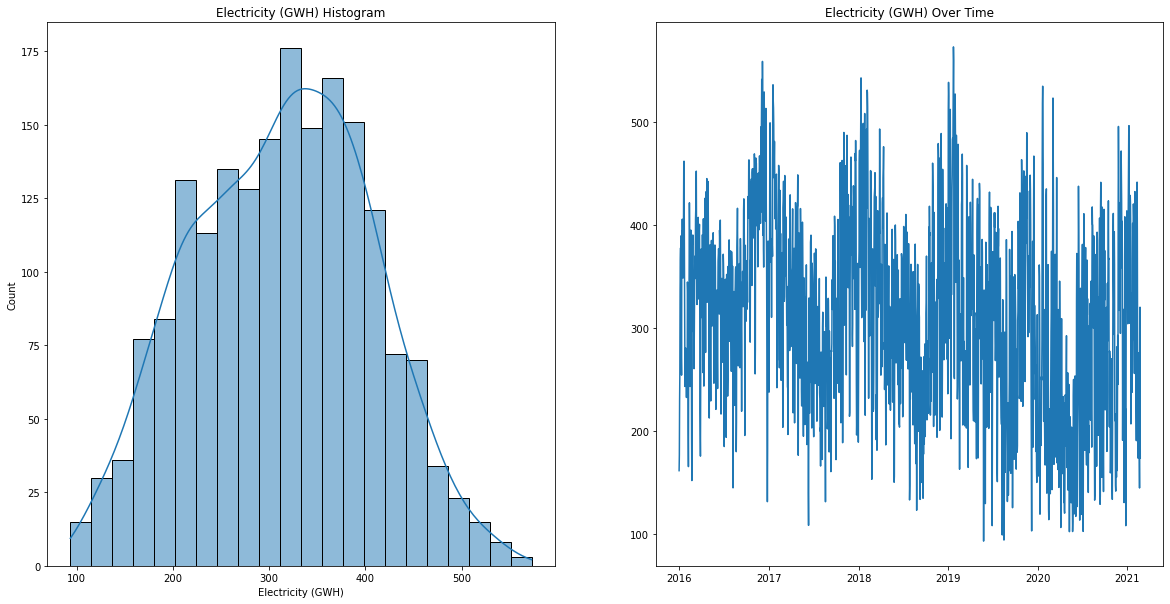

In [4]:
plot_series(daily_elec_GWH.rename("Electricity (GWH)"))

The energy provided by gas is derived from two primary attributes, its' volume and calorifiv value (CV). Volume is measured in MCM (million cubic meters) and refers to the quantity of gas in question. The CV is dependent on the gas content, and refers to the amount of energy released by the gas when a fixed volume is combusted.  [The CV of gas, which is dry, gross and measured at standard conditions of temperature (15oC) and pressure (1013.25 millibars), is usually quoted in megajoules per cubic metre (MJ/m3). Gas passing through our pipeline system has a CV of 37.5 MJ/m3 to 43.0 MJ/m3.]

This means to calculate the energy used we can start by multiplying the volume by the calorific value. Handily for us, this has already been created as a data set along with CV and Volume in the raw dataset source.

In [5]:
key = "GAS_ENERGY"
raw_gas_energy_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_energy_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)


gas_energy = make_dataset.prepare_gas_data(raw_gas_energy_path).rename(
    {"VALUE": "ENERGY"}, axis=1
)
# kWH

gas_energy = make_dataset.map_to_sites(gas_energy)

# clean up the data types
gas_energy["ENERGY"] = (
    gas_energy["ENERGY"].str.replace(",", "").astype(float)
)  # some rogue string characters in there
gas_energy["ENERGY_GWH"] = gas_energy["ENERGY"] / 1000000

# calculate the daily average energy for all Powerstations
daily_gas_energy = gas_energy.groupby("GAS_DAY")["ENERGY_GWH"].sum().tz_localize(None)

C:\Users\rachel.hassall\.conda\envs\charterful\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


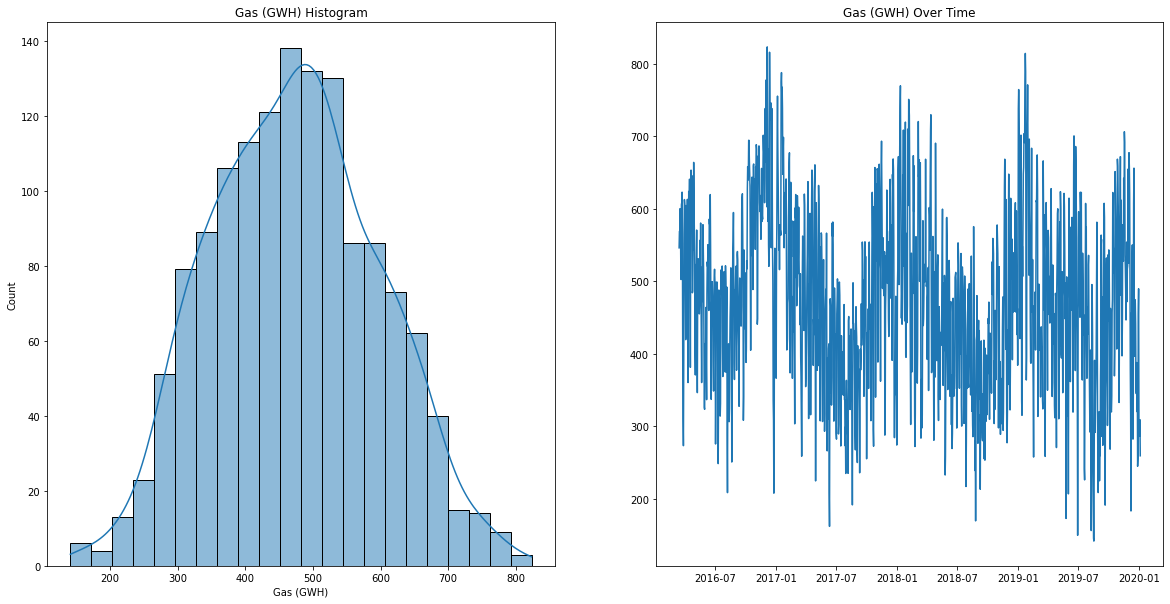

In [6]:
plot_series(daily_gas_energy.rename("Gas (GWH)"))

Now we have both daily UK Gas and Electricity usage of powerstations in GWH, we can calculate the Efficiency. Looking at the plot of Efficiency over time, there's some pretty high values (over 80%!) in there which don't align with offline research of expected efficiency values of around 50% to 60%. Let's investigate that further!

In [7]:
df = pd.DataFrame({"ELECTRICITY": daily_elec_GWH, "GAS": daily_gas_energy}).dropna()
df["EFFICIENCY"] = df["ELECTRICITY"] / df["GAS"]
df["EFFICIENCY"].describe()

count    1393.000000
mean        0.687192
std         0.052073
min         0.527030
25%         0.657998
50%         0.688107
75%         0.715965
max         0.895248
Name: EFFICIENCY, dtype: float64

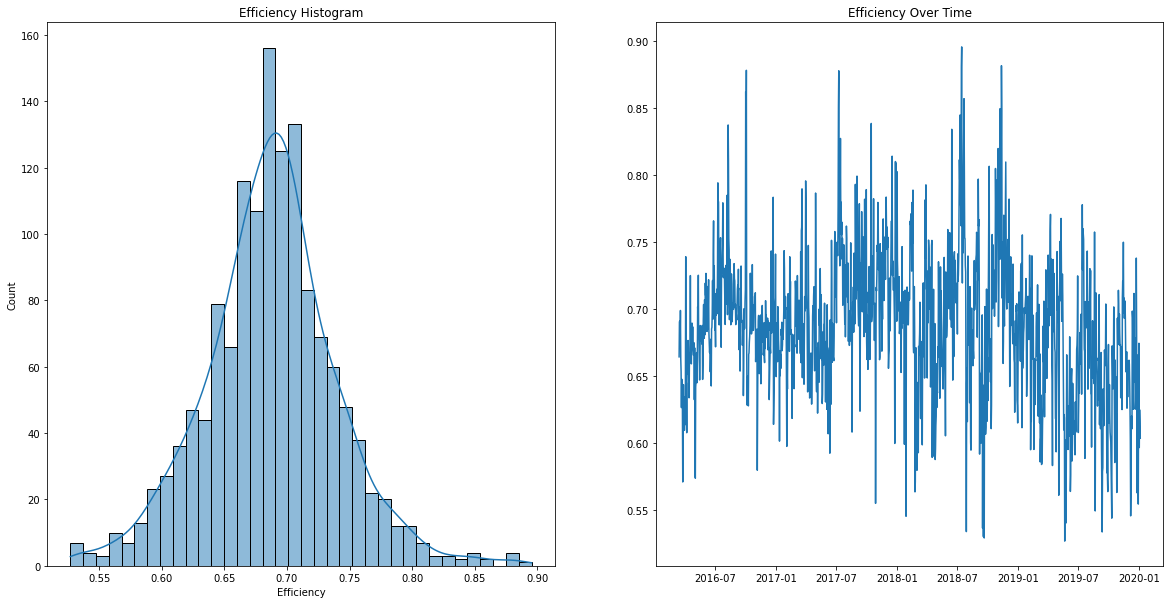

In [8]:
plot_series(df["EFFICIENCY"].rename("Efficiency"))

## Does Energy = Volume * CV?

One source of error in these high efficiency values could be the data, let's cross check the raw Energy data with recalculating it from both Volume and CV.

- Calorific value is in MJ/scm
- Energy is in kWh
- Volume is in mscm

### Volume

In [9]:
key = "GAS_VOLUME"
raw_gas_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_volume = make_dataset.prepare_gas_data(raw_gas_volume_path).rename(
    {"VALUE": "VOLUME"}, axis=1
)
# kWH

gas_volume = make_dataset.map_to_sites(gas_volume)
gas_volume.head()

,ITEM,GAS_DAY,VOLUME,SITE
17,"NTS PHYSICAL FLOWS, BAGLANBAY, NTS POWER STATION",2016-03-14,1.72800,BAGLANBAY
23,"NTS PHYSICAL FLOWS, BLACKBRIDGE, NTS POWER STA...",2016-03-14,8.12001,BLACKBRIDGE
33,"NTS PHYSICAL FLOWS, BRIGG, NTS POWER STATION",2016-03-14,0.00000,BRIGG
38,"NTS PHYSICAL FLOWS, BURTONPOINT, NTS POWER STA...",2016-03-14,0.40800,BURTONPOINT
48,"NTS PHYSICAL FLOWS, CORBY, NTS POWER STATION",2016-03-14,0.00000,CORBY


Now we have the gas volumes per powerstation, we can do some quick sense checks and get a feel for the distributions. Everything looks sensible (e.g. no negative volumes)!

No handles with labels found to put in legend.


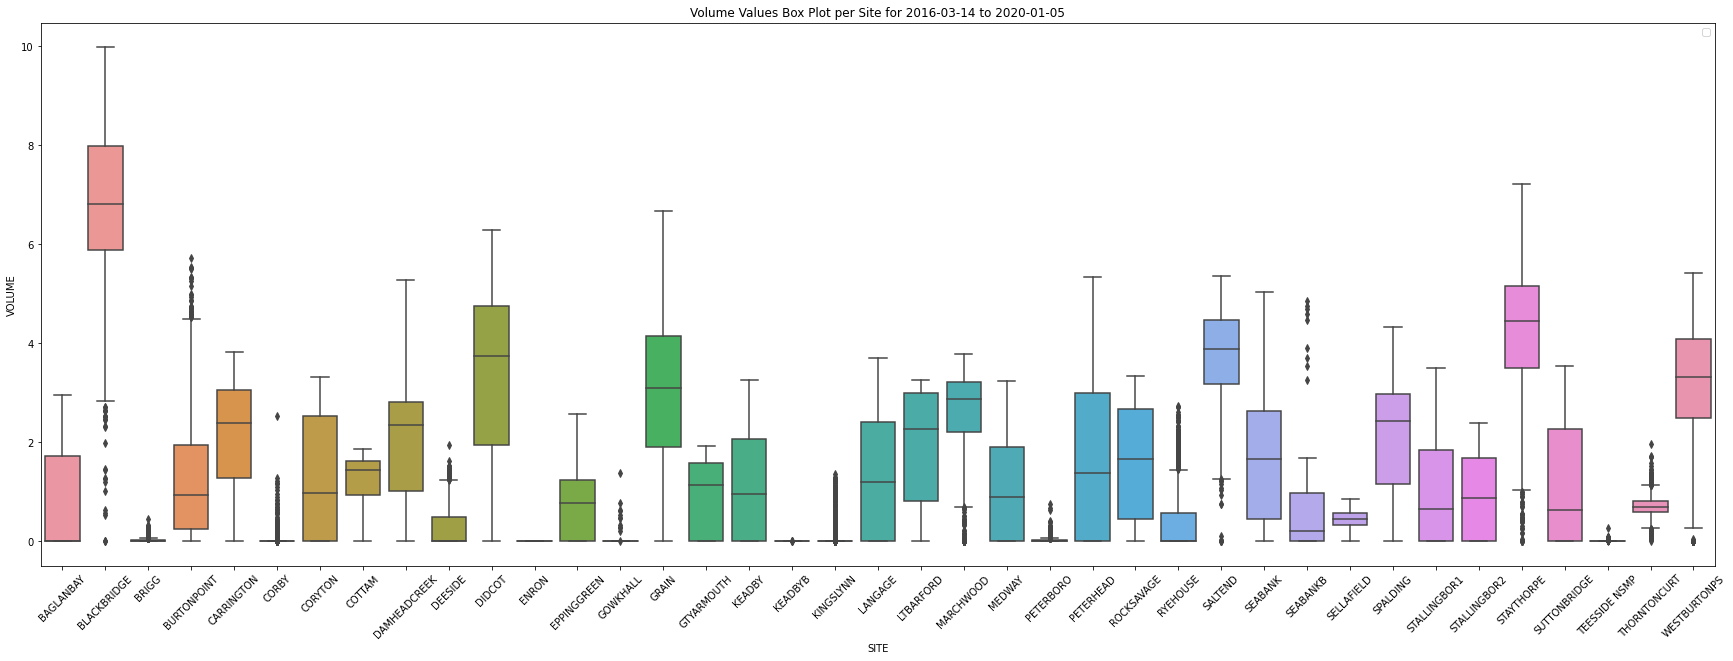

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

sns.boxplot(x="SITE", y="VOLUME", data=gas_volume, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(
    f"Volume Values Box Plot per Site for {gas_volume.GAS_DAY.dt.date.min()} to {gas_volume.GAS_DAY.dt.date.max()}"
)

plt.legend()
plt.show()

### CV

In [11]:
key = "GAS_CV"
raw_gas_cv_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_cv_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_cv = make_dataset.prepare_gas_data(raw_gas_cv_path).rename({"VALUE": "CV"}, axis=1)
# kWH

gas_cv = make_dataset.map_to_sites(gas_cv)
# MJ/scm
gas_cv.head()

,ITEM,GAS_DAY,CV,SITE
17,"CALORIFIC VALUE, BAGLANBAY, NTS POWER STATION",2016-03-14,39.21,BAGLANBAY
23,"CALORIFIC VALUE, BLACKBRIDGE, NTS POWER STATION",2016-03-14,39.15,BLACKBRIDGE
33,"CALORIFIC VALUE, BRIGG, NTS POWER STATION",2016-03-14,39.74,BRIGG
38,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-14,39.78,BURTONPOINT
49,"CALORIFIC VALUE, CORBY, NTS POWER STATION",2016-03-14,39.19,CORBY


The calorific data looks correct, as it varies within the CV system range of 37.5 MJ/m3 to 43.0 MJ/m3 stated in the literature - this gives us confidence in this CV data! Some sites (Burtonpoint, Grain GtYarmouth, Peterhead, Stallingborough) have dropped below the system range minimum, but this seems uncommon. We also lose CV data for Deeside (it's 0!).

In [12]:
gas_cv[gas_cv["CV"] == 0]["SITE"].unique()

['DEESIDE']
Categories (1, object): ['DEESIDE']

In [13]:
gas_cv[gas_cv["CV"] != 0]["CV"].describe()

count    52114.000000
mean        39.418449
std          0.526722
min         29.420000
25%         39.180000
50%         39.390000
75%         39.600000
max         42.980000
Name: CV, dtype: float64

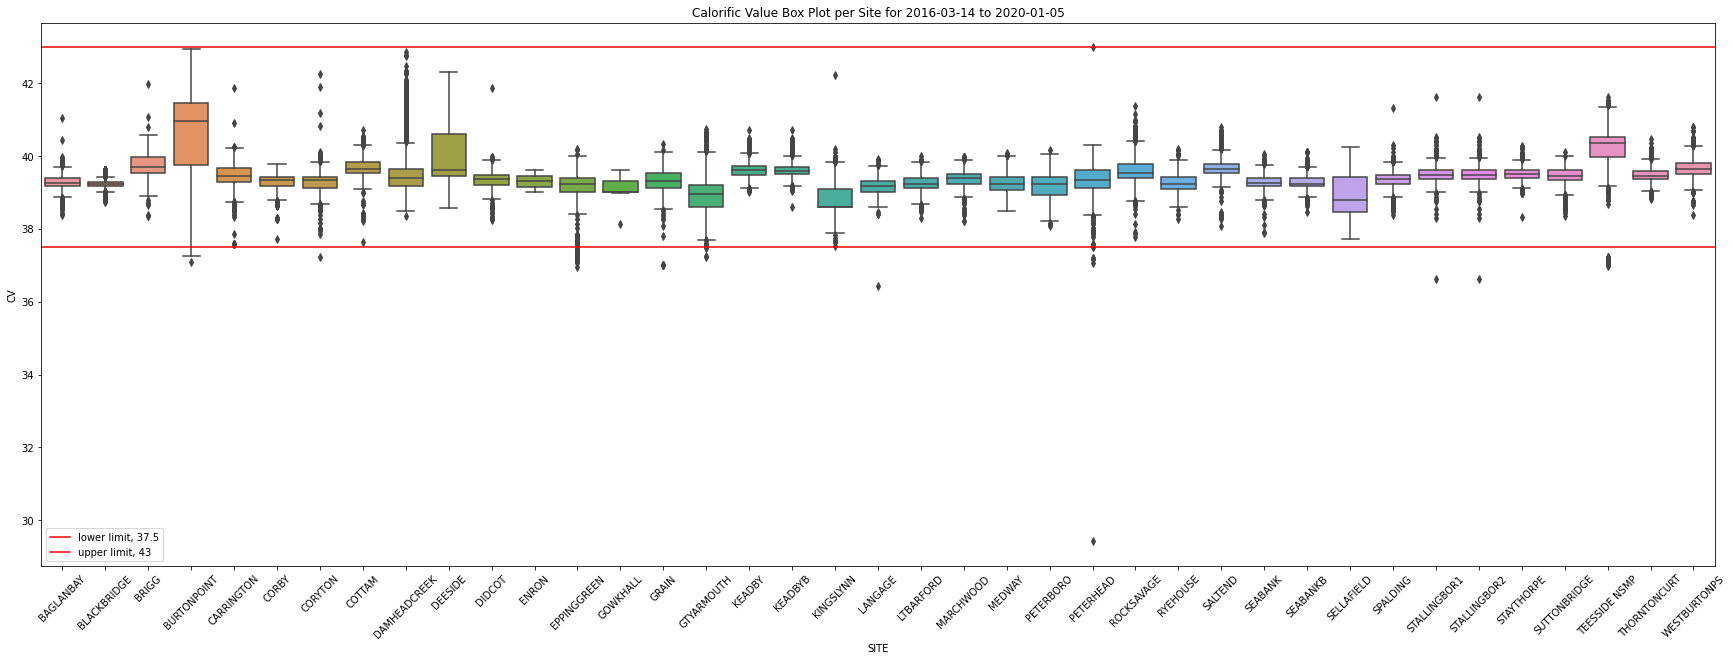

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

sns.boxplot(x="SITE", y="CV", data=gas_cv[gas_cv["CV"] > 0], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title(
    f"Calorific Value Box Plot per Site for {gas_cv.GAS_DAY.dt.date.min()} to {gas_cv.GAS_DAY.dt.date.max()}"
)
plt.axhline(37.5, label="lower limit, 37.5", c="r")
plt.axhline(43, label="upper limit, 43", c="r")
plt.legend()
plt.show()

## Compare Energy and Volume*CV

[TO DO - explain this calculation a bit more]

- Energy is in kWh
- Calorific value is in MJ/scm
- Volume is in mscm

Calorific Value * Volume = X 10^6 MJ = X * 10^6 * 10^6 J = X * 10^6 * 10^6 / 1000 kJ


Energy = Y kWh = Y *1000 J/s * h = Y * 1000 J/s * 60 * 60 s = Y * 60 *60 J

1 kWh = 3.6 MJ


In [15]:
# get all the data in one dataframe to compare
compare = gas_volume.merge(
    gas_cv, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)
compare = compare.merge(
    gas_energy, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)

# create our energy col
compare["VOLUME_MULT_CV"] = compare["VOLUME"] * compare["CV"]
compare["VOLUME_MULT_CV_GWH"] = compare["VOLUME_MULT_CV"] / 3.6

# compare
compare = compare[
    ["GAS_DAY", "SITE", "VOLUME", "CV", "VOLUME_MULT_CV_GWH", "ENERGY_GWH",]
]

compare["DIFF_ENERGY"] = compare["ENERGY_GWH"] - compare["VOLUME_MULT_CV_GWH"]
compare

,GAS_DAY,SITE,VOLUME,CV,VOLUME_MULT_CV_GWH,ENERGY_GWH,DIFF_ENERGY
0,2016-03-14,BAGLANBAY,1.72800,39.21,18.820800,18.816562,-0.004238
1,2016-03-14,BLACKBRIDGE,8.12001,39.15,88.305109,88.322211,0.017102
2,2016-03-14,BRIGG,0.00000,39.74,0.000000,0.000000,0.000000
3,2016-03-14,BURTONPOINT,0.40800,39.78,4.508400,4.504462,-0.003938
4,2016-03-14,CORBY,0.00000,39.19,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
52333,2020-01-05,STAYTHORPE,1.32000,39.45,14.465000,14.455556,-0.009444
52334,2020-01-05,SUTTONBRIDGE,0.21300,39.33,2.327025,2.327778,0.000753
52335,2020-01-05,TEESSIDE NSMP,0.01398,39.57,0.153664,0.153610,-0.000054
52336,2020-01-05,THORNTONCURT,0.57290,39.32,6.257341,6.258889,0.001548


There is consistently a small difference in energy vs volume*CV between sites (they should be the same). Looking at the total difference per day this is centred near 0 but can increase quite high both positively and negatively.

In [16]:
compare["DIFF_ENERGY"].describe()

count    38411.000000
mean        -0.009799
std          0.656229
min        -54.510192
25%         -0.002326
50%          0.000000
75%          0.000699
max         35.591667
Name: DIFF_ENERGY, dtype: float64

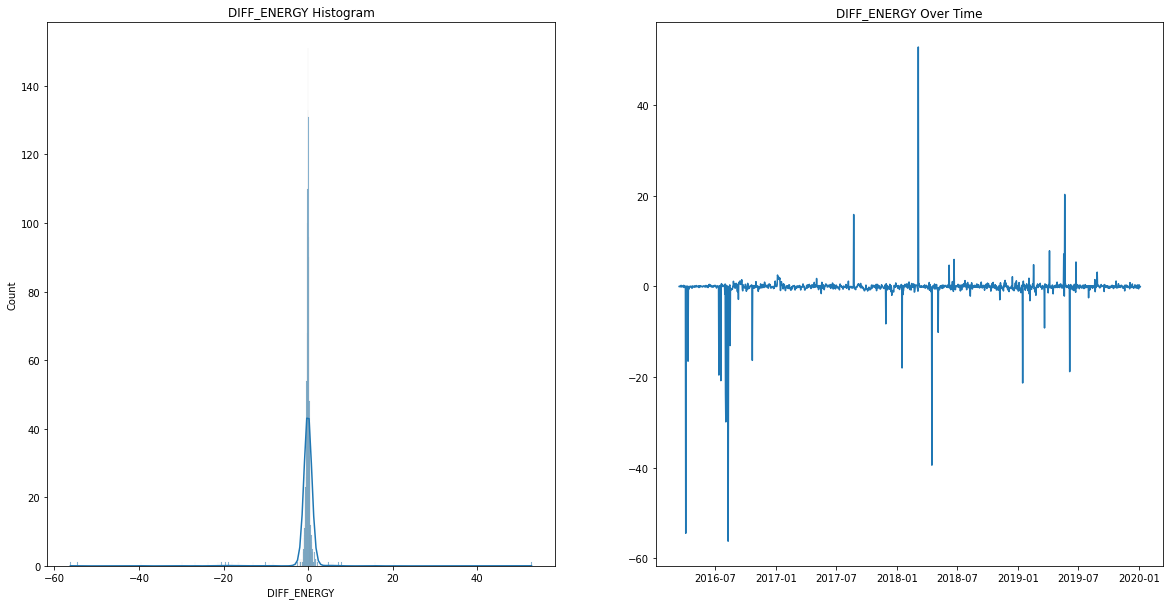

In [17]:
plot_series(compare.groupby("GAS_DAY")["DIFF_ENERGY"].sum())

It looks like there are some blips in differences between Energy and Volume*CV, across multiple sites, interesting! I wonder which is correct... It doesn't seem to be limited to a single site.

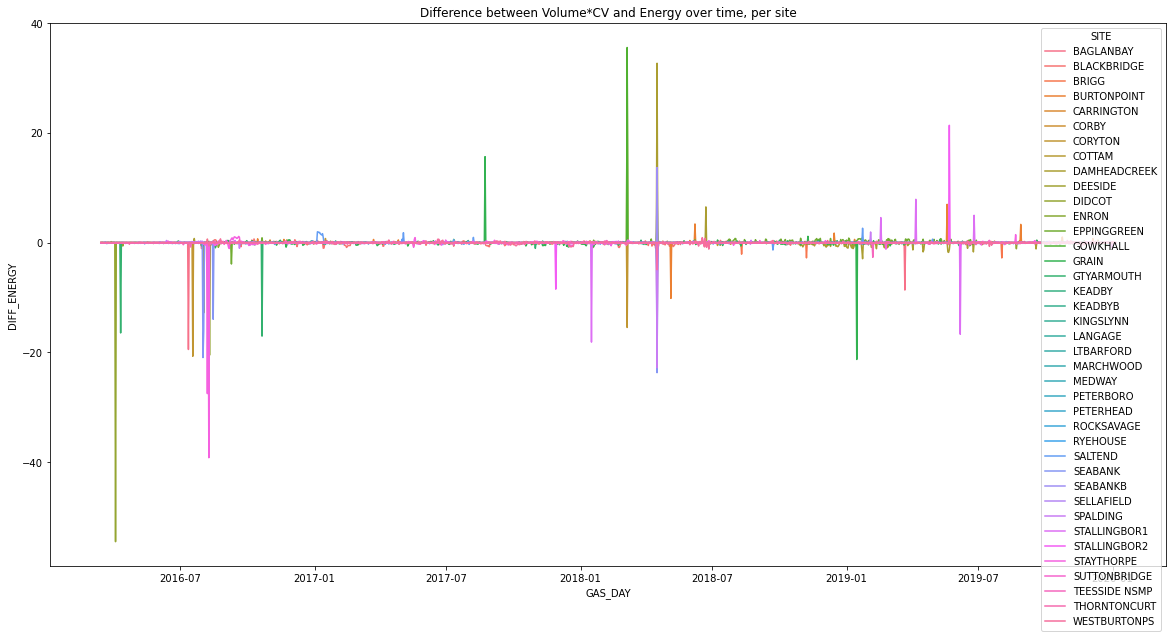

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=compare, x="GAS_DAY", y="DIFF_ENERGY", hue="SITE", ax=ax,
)
plt.title("Difference between Volume*CV and Energy over time, per site")
plt.show()

The raw energy data seems to be lower than that calculated using Volume and CV.

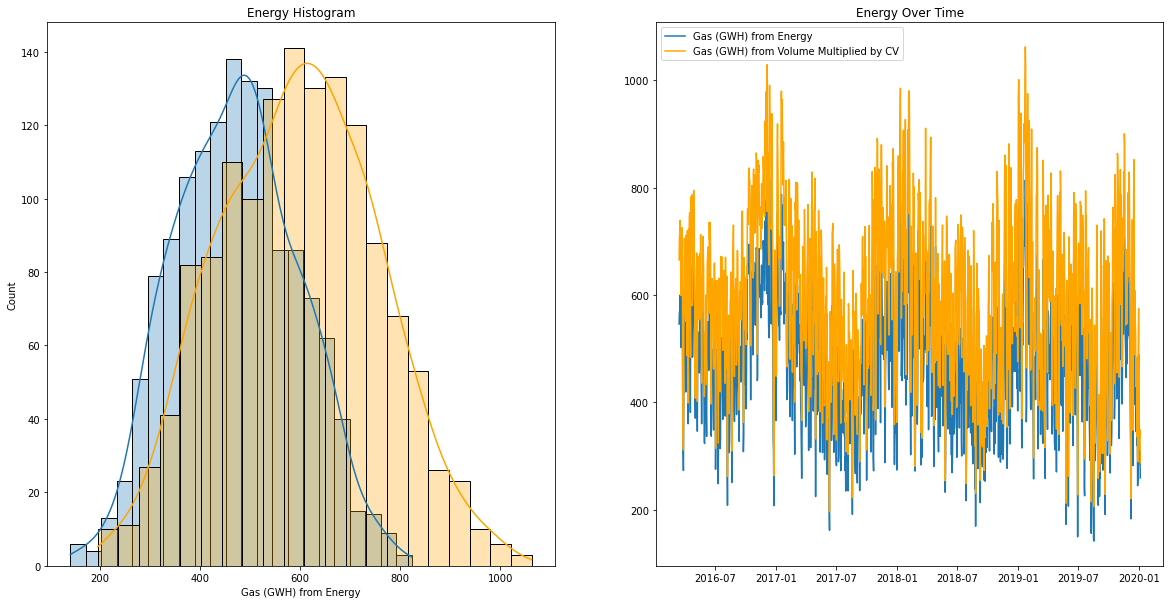

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title(f"Energy Histogram")
ax[1].set_title(f"Energy Over Time")

# the energy from the data
timeseries = daily_gas_energy.rename("Gas (GWH) from Energy")
sns.histplot(timeseries, kde=True, ax=ax[0], label=timeseries.name, alpha=0.3)
ax[1].plot(timeseries, label=timeseries.name)

# calculate the daily average energy for all Powerstations
daily_gas_volume_mult_cv = (
    compare.groupby("GAS_DAY")["VOLUME_MULT_CV_GWH"].sum().tz_localize(None)
)
timeseries = daily_gas_volume_mult_cv.rename("Gas (GWH) from Volume Multiplied by CV")
sns.histplot(
    timeseries, kde=True, ax=ax[0], label=timeseries.name, alpha=0.3, color="orange"
)
ax[1].plot(timeseries, label=timeseries.name, color="orange")
ax[1].legend()
plt.show()

Worth investigating down the line where these differences come from. For our final comparison, let's calculate efficiency with the energy values dereived from volume and CV, to see if these give more realistic efficiency values.

This does indeed seem to reduce our efficiencies down to reasonable levels, fantastic! We shall use our the calculated Energy (from Volume and CV) for the remainder of this analysis.

In [29]:
df = pd.DataFrame(
    {"ELECTRICITY": daily_elec_GWH, "GAS": daily_gas_volume_mult_cv}
).dropna()
df["EFFICIENCY"] = df["ELECTRICITY"] / df["GAS"]
df["EFFICIENCY"].describe()

count    1393.000000
mean        0.543969
std         0.020303
min         0.440361
25%         0.532200
50%         0.544305
75%         0.555938
max         0.668640
Name: EFFICIENCY, dtype: float64

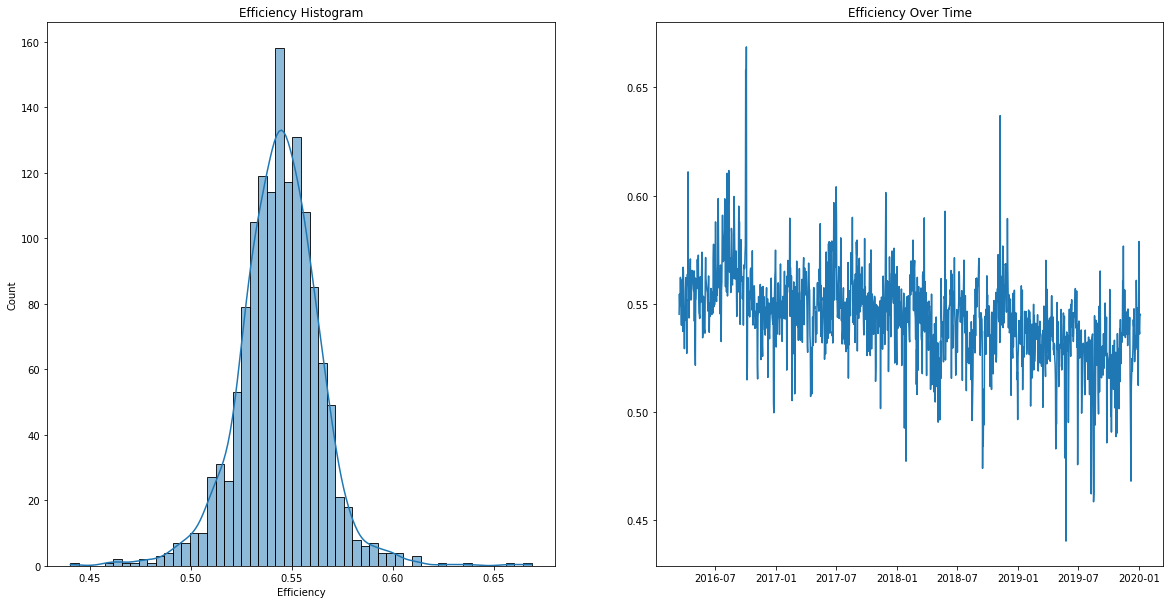

In [30]:
plot_series(df["EFFICIENCY"].rename("Efficiency"))

# How efficient are individual gas fired power stations?

We have total electricity actual data, and individual gas power station data. If we had individual electricity actual data it would be simple to calculate each individual powerstation's efficiency but as it stands we don't. However, maybe there is a way around this. Can we solve it without?

We know...

Electricity Energy = Efficiency * Gas Energy

Electricity Energy (UK) = Efficiency (Powerstation A) * Gas Energy (Powerstation A) + Efficiency (Powerstation B) * Gas Energy (Powerstation B) + ....

$ UK Electricity Energy = \sum \limits _{i=1}  (Efficiency)_{i}*{(Gas Energy)}_{i} $

We have this equation for various time periods, creating a series of simultaneous equations and an overdetermined system (more equations than required to solve, meaning some variations in the solution and not one clear solution.

[https://dwightreid.com/blog/2015/09/21/python-how-to-solve-simultaneous-equations/]
[https://en.wikipedia.org/wiki/Overdetermined_system]

In [32]:
# we set up our equations as a dataframe of multiple days, where each day is an equation
gas_powerstations = (
    compare.groupby(["GAS_DAY", "SITE"])["VOLUME_MULT_CV_GWH"].sum().unstack()
)
equations_df = df.merge(gas_powerstations, left_index=True, right_index=True).drop(
    ["GAS", "EFFICIENCY"], axis=1
)
equations_df.head()

,ELECTRICITY,BAGLANBAY,BLACKBRIDGE,BRIGG,BURTONPOINT,CARRINGTON,CORBY,CORYTON,COTTAM,DAMHEADCREEK,...,SEABANKB,SELLAFIELD,SPALDING,STALLINGBOR1,STALLINGBOR2,STAYTHORPE,SUTTONBRIDGE,TEESSIDE NSMP,THORNTONCURT,WESTBURTONPS
GAS_DAY,,,,,,,,,,,,,,,,,,,,,
2016-03-14,362.7460,18.820800,88.305109,0.0,4.508400,0.0,0.0,0.000000,16.381783,28.162952,...,0.000000,6.856192,26.119624,13.126986,0.0,47.877914,27.128444,0.0,6.557813,29.619889
2016-03-15,392.7550,20.070400,90.905480,0.0,6.851140,0.0,0.0,0.000000,14.150221,28.378930,...,0.000000,6.869108,33.012509,12.152930,0.0,55.341519,24.287694,0.0,7.073477,28.581880
2016-03-16,393.2615,19.087139,93.481002,0.0,4.285084,0.0,0.0,0.000000,19.215700,28.235037,...,0.435133,6.950579,32.856884,13.188274,0.0,51.202090,19.532903,0.0,9.834221,32.598720
2016-03-17,406.4755,20.169560,86.904440,0.0,14.747552,0.0,0.0,0.000000,17.615189,28.167780,...,11.073113,7.053307,32.005159,20.173457,0.0,38.570522,22.715600,0.0,6.964273,35.880283
2016-03-18,407.2865,20.052197,96.429172,0.0,23.412927,0.0,0.0,0.006512,17.303125,29.227487,...,0.000000,5.428625,32.314143,20.224020,0.0,32.182415,28.391000,0.0,8.232894,38.146450


We know the bounds of the solution, i.e. non-negative between 0 and 1, so we use a bounded linear least squares solver.

In [34]:
from scipy.optimize import lsq_linear

equation_efficiencies = lsq_linear(
    equations_df[gas_powerstations.columns].values,
    equations_df["ELECTRICITY"].values,
    bounds=(0, 1),  # efficiencies should be between 0 and 1
    verbose=2,
)

equation_efficiencies

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         6.5071e+04                                    1.72e+05    
       1         5.6769e+04      8.30e+03       1.55e-01       3.48e+04    
       2         5.6356e+04      4.14e+02       1.14e-01       2.66e+03    
       3         5.5873e+04      4.83e+02       6.63e-01       1.99e+02    
       4         5.5707e+04      1.66e+02       3.12e-01       3.43e+01    
       5         5.5672e+04      3.52e+01       2.08e-02       2.51e+00    
       6         5.5669e+04      2.74e+00       1.74e-03       1.65e-02    
       7         5.5669e+04      1.72e-02       1.14e-05       8.36e-05    
       8         5.5669e+04      8.80e-05       5.83e-08       7.02e-09    
       9         5.5669e+04      7.39e-09       4.90e-12       5.04e-10    
The relative change of the cost function is less than `tol`.
Number of iterations 10, initial cost 6.5071e+04, final cost 5.5669e+04, first-order optimality 5.04e-1

 active_mask: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0])
        cost: 55668.90779997654
         fun: array([ 3.62161224, -1.49710368,  1.95411906, ..., -2.26570606,
       -8.92042888, -5.76767539])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 10
  optimality: 5.035505374005272e-10
      status: 2
     success: True
           x: array([6.93509122e-01, 4.75652638e-01, 6.14499210e-01, 5.13792691e-01,
       4.52441221e-01, 4.18269076e-01, 5.06656686e-01, 3.92867365e-01,
       6.72720692e-01, 1.00000000e+00, 5.14027386e-01, 1.00000000e-01,
       4.14238651e-01, 1.00000000e+00, 6.16100153e-01, 5.46415901e-01,
       5.79025482e-01, 9.77908414e-25, 3.71588868e-01, 6.54399825e-01,
       5.51601279e-01, 6.75653495e-01, 4.79402702e-01, 6.21155539e-01,
       5.05954790e-01, 5.90504824e-01, 4.90471159e-01, 6.29

The results show some super high and low alues, albeit more realistic. Let's further reduce the bounds to a more realistic solution.

In [35]:
dict(zip(gas_powerstations.columns, equation_efficiencies.x))

{'BAGLANBAY': 0.6935091217720427,
 'BLACKBRIDGE': 0.4756526383545819,
 'BRIGG': 0.6144992100047235,
 'BURTONPOINT': 0.5137926909624148,
 'CARRINGTON': 0.45244122071237153,
 'CORBY': 0.4182690756757522,
 'CORYTON': 0.5066566862123504,
 'COTTAM': 0.3928673654791052,
 'DAMHEADCREEK': 0.6727206917365993,
 'DEESIDE': 0.9999999999999999,
 'DIDCOT': 0.5140273860151393,
 'ENRON': 0.1,
 'EPPINGGREEN': 0.41423865103968227,
 'GOWKHALL': 0.9999999999999999,
 'GRAIN': 0.6161001528022344,
 'GTYARMOUTH': 0.5464159005885253,
 'KEADBY': 0.5790254818116337,
 'KEADBYB': 9.779084136250261e-25,
 'KINGSLYNN': 0.3715888680827427,
 'LANGAGE': 0.6543998248684232,
 'LTBARFORD': 0.551601279014818,
 'MARCHWOOD': 0.675653494905483,
 'MEDWAY': 0.47940270216704534,
 'PETERBORO': 0.6211555390590143,
 'PETERHEAD': 0.505954790079637,
 'ROCKSAVAGE': 0.5905048240206678,
 'RYEHOUSE': 0.4904711589332516,
 'SALTEND': 0.6296997095798204,
 'SEABANK': 0.5499984383691051,
 'SEABANKB': 0.5019823819108771,
 'SELLAFIELD': 0.845698

In [36]:
equation_efficiencies = lsq_linear(
    equations_df[gas_powerstations.columns].values,
    equations_df["ELECTRICITY"].values,
    bounds=(0.2, 0.9),
    verbose=2,
)

equation_efficiencies

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         8.2273e+04                                    1.64e+05    
       1         5.8882e+04      2.34e+04       2.43e-01       6.32e+03    
       2         5.7166e+04      1.72e+03       4.10e-01       9.16e+02    
       3         5.6533e+04      6.33e+02       2.47e-01       1.74e+02    
       4         5.6378e+04      1.55e+02       1.54e-01       1.43e+01    
       5         5.6364e+04      1.42e+01       1.35e-02       1.36e-01    
       6         5.6363e+04      1.37e-01       1.69e-04       1.28e-05    
       7         5.6363e+04      1.29e-05       2.18e-08       1.65e-10    
       8         5.6363e+04      1.65e-10       2.81e-13       1.42e-10    
The relative change of the cost function is less than `tol`.
Number of iterations 9, initial cost 8.2273e+04, final cost 5.6363e+04, first-order optimality 1.42e-10.


 active_mask: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0])
        cost: 56363.392125637176
         fun: array([ 3.48563664, -1.59411266,  1.93104297, ..., -2.01392482,
       -8.55850168, -5.68756923])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.4162490195327647e-10
      status: 2
     success: True
           x: array([0.71269267, 0.46983915, 0.49900649, 0.51625479, 0.44901336,
       0.39759186, 0.50321656, 0.38153324, 0.67308559, 0.9       ,
       0.51446624, 0.4       , 0.41883048, 0.9       , 0.61033576,
       0.55043822, 0.58734499, 0.2       , 0.33589294, 0.6564851 ,
       0.55620252, 0.66882488, 0.48324847, 0.55659536, 0.50007634,
       0.59148838, 0.49597248, 0.62758604, 0.55225335, 0.50259474,
       0.76348492, 0.5297843 , 0.41750848, 0.43002886, 0.5982964 ,
       0.451338

Some of these look a little off, e.g. Teesside NSMP, ThorntonCurt.

In [37]:
dict(zip(gas_powerstations.columns, equation_efficiencies.x))

{'BAGLANBAY': 0.7126926748726649,
 'BLACKBRIDGE': 0.4698391533694381,
 'BRIGG': 0.499006489237169,
 'BURTONPOINT': 0.5162547929159554,
 'CARRINGTON': 0.44901335702477213,
 'CORBY': 0.39759185939431746,
 'CORYTON': 0.5032165630626901,
 'COTTAM': 0.38153324235589586,
 'DAMHEADCREEK': 0.6730855875802476,
 'DEESIDE': 0.8999999999999999,
 'DIDCOT': 0.5144662442847171,
 'ENRON': 0.4000000000000628,
 'EPPINGGREEN': 0.41883047544890006,
 'GOWKHALL': 0.8999999999999999,
 'GRAIN': 0.6103357621752917,
 'GTYARMOUTH': 0.5504382164278945,
 'KEADBY': 0.5873449859470644,
 'KEADBYB': 0.20000000000000004,
 'KINGSLYNN': 0.33589293554682836,
 'LANGAGE': 0.656485098916203,
 'LTBARFORD': 0.5562025245693738,
 'MARCHWOOD': 0.6688248758163583,
 'MEDWAY': 0.48324846851084613,
 'PETERBORO': 0.5565953626621781,
 'PETERHEAD': 0.5000763385971926,
 'ROCKSAVAGE': 0.591488379105471,
 'RYEHOUSE': 0.49597248429602203,
 'SALTEND': 0.6275860440551995,
 'SEABANK': 0.552253347429545,
 'SEABANKB': 0.5025947421231127,
 'SELLA

We could sense check these values with a random spot check using maximum capacity data from https://electricityproduction.uk/plant/. A quick look at some of the 0.2 values, indicates these sites also have wind farms, interesting!